## 1. Determinación de la Frecuencia de Muestreo ($f_s$)

Antes de realizar cualquier análisis espectral, el primer paso crítico fue establecer la **Frecuencia de Muestreo ($f_s$)** de mi señal.

Dado que cuento con el vector de tiempo $t$, necesito calcular el intervalo temporal ($\Delta t$) entre dos puntos consecutivos de la medición. Asumiendo un muestreo uniforme, la diferencia entre el segundo y el primer dato (`t[1] - t[0]`) me entrega el paso de tiempo o resolución temporal.

La frecuencia de muestreo es simplemente el inverso de este intervalo:

$$f_s = \frac{1}{\Delta t}$$

**¿Por qué es esto fundamental para mi análisis?**
Este valor no solo define la resolución temporal, sino que establece el límite físico de mi análisis en frecuencia. Según el **Teorema de Nyquist**, la frecuencia máxima que podré detectar confiablemente en el espectro será la mitad de esta $f_s$ (conocida como Frecuencia de Nyquist). Cualquier componente por encima de $f_s / 2$ generaría *aliasing* (falsas frecuencias), por lo que definir correctamente este parámetro es la base de todo el procesamiento posterior.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# tiempo (segundos)
t = np.linspace(0, 5, 500)

# Señal de vibración (simulada)
senal = np.sin(2 * np.pi * 30 * t) + 0.2 * np.random.rand(len(t))

# Señal alterada de vibración (simulada)
senal_alterada = senal + 0.5 * np.random.randn(len(senal))

dt = t[1] - t[0]
fs = 1 / dt
print("fs:", fs, "Hz")


fs: 99.8 Hz


## 2. Eliminación del DC Offset (Centrado de la Señal)

Al inspeccionar la señal cruda, noté que los valores no oscilaban alrededor de cero, sino que estaban desplazados verticalmente. En el mundo del procesamiento de señales, a este fenómeno se le conoce como **DC Offset** o *Componente de Continua*.

Esto suele ocurrir porque los acelerómetros (especialmente los piezoeléctricos tipo IEPE) operan sobre un voltaje de polarización (Bias Voltage) para transmitir la data.

Decidí eliminar este desplazamiento restando el valor promedio a toda la señal:

$$x_{centrada}(t) = x(t) - \mu$$

**¿Por qué es necesario este paso?**
Si ingreso la señal con este desplazamiento al algoritmo de FFT, la transformada interpretará ese valor constante como una "vibración de frecuencia cero" con una amplitud gigantesca. Esto generaría un pico enorme en **0 Hz** que aplastaría visualmente el resto de las frecuencias dinámicas (las que realmente me importan), dificultando el análisis de los componentes mecánicos. Al centrar la señal en cero, garantizo un espectro limpio y escalado correctamente.

In [12]:
senal0 = senal - np.mean(senal)

## 3. Cálculo del Espectro (FFT Unilateral)

Llegado a este punto, apliqué la **Transformada Rápida de Fourier (FFT)** para descomponer la señal en sus frecuencias constitutivas.

Para optimizar el cálculo, tomé una decisión técnica importante: utilicé `np.fft.rfft` (Real FFT) en lugar de la `fft` estándar.

**¿Por qué `rfft`?**
Dado que mi señal de vibración es **real** (no contiene números imaginarios), su espectro es simétrico: la mitad negativa es un "espejo" redundante de la positiva (simetría conjugada).
* `fft`: Calcula ambas mitades (frecuencias positivas y negativas).
* `rfft`: Calcula solo las frecuencias **positivas**, lo cual es más eficiente computacionalmente y me entrega directamente el espectro unilateral que se utiliza en ingeniería.



**Normalización de la Magnitud**
El output de la FFT son números complejos ($a + bi$). Para obtener la amplitud física (Voltios, G's, mm/s), realicé dos operaciones:

1.  **Módulo (`np.abs`):** Calculé la magnitud del vector complejo ($\sqrt{Re^2 + Im^2}$).
2.  **Escalado (`2/N`):** Este factor es vital para recuperar la amplitud real de la señal física:
    * Divido por **N** (número de muestras) para normalizar la suma de la FFT.
    * Multiplico por **2** para compensar la energía que "perdí" al descartar la mitad negativa del espectro.

$$Magnitud = \frac{2}{N} \cdot |FFT|$$

El resultado almacenado en `mag` representa ahora la amplitud pico (Peak) de cada componente de frecuencia.

In [13]:
N = len(senal0)

Y = np.fft.rfft(senal0)
freqs = np.fft.rfftfreq(N, d=dt)

mag = (2.0 / N) * np.abs(Y)   # escala simple para magnitud (aprox)


## 4. Visualización del Espectro (Enfoque en Baja Frecuencia)

Una vez procesada la data, procedí a graficar el espectro de frecuencia (`freqs` vs `mag`).

Sin embargo, tomé una decisión de visualización estratégica: en lugar de graficar el ancho de banda completo (que podría extenderse hasta miles de Hz dependiendo de mi $f_s$), apliqué un límite en el eje X con `plt.xlim(0, 200)`.

**¿Por qué este recorte a 200 Hz?**
En el análisis de maquinaria rotativa estándar, la mayoría de los fallos estructurales críticos ocurren en los primeros armónicos de la velocidad de giro (1X, 2X, 3X).
* Si mi máquina gira a 3000 RPM (50 Hz), sus fallos principales aparecerán en 50, 100 y 150 Hz.
* Al limitar la vista a **0-200 Hz**, evito que el "ruido" de alta frecuencia o los componentes de rodamientos distraigan del diagnóstico primario (Desbalance y Desalineación).



Este "Zoom Útil" me permite inspeccionar con claridad la amplitud de los picos dominantes sin perder resolución visual.

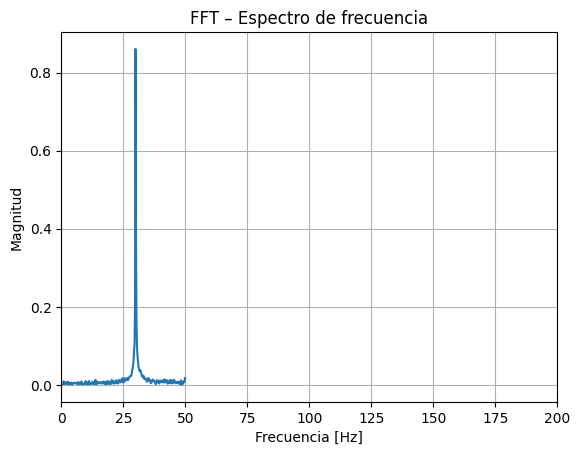

In [14]:
plt.figure()
plt.plot(freqs, mag)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud")
plt.title("FFT – Espectro de frecuencia")
plt.xlim(0, 200)
plt.grid(True)
plt.show()

## 5. Detección Automática de la Frecuencia Dominante y RPM

Finalmente, implementé una lógica simple para extraer la métrica más importante de forma automática: la **Velocidad de Giro**.

En la mayoría de los equipos rotativos simples, la vibración con mayor amplitud (el pico más alto) suele corresponder a la frecuencia de rotación del eje (el 1X), especialmente si existe algún grado de desbalance residual.

Para encontrar este valor programáticamente, utilicé `np.argmax`, pero con una **precaución técnica**:
`idx = np.argmax(mag[1:]) + 1`

**¿Por qué el slice `[1:]` y el `+1`?**
Decidí ignorar deliberadamente el índice 0 (0 Hz). Aunque ya había restado el promedio (DC Offset), a veces queda un residuo matemático de muy baja frecuencia o "deriva" instrumental cerca del cero. Si no lo filtro, el algoritmo podría decirme erróneamente que la frecuencia dominante es 0 Hz. Al buscar el máximo a partir del índice 1 y luego corregir el desplazamiento del índice (`+1`), garantizo encontrar el pico **dinámico** real.

**Conversión a RPM**
Una vez identificada la frecuencia en Hertz ($f_{peak}$), realicé la conversión estándar de la industria para obtener las Revoluciones por Minuto:

$$RPM = f_{peak} \times 60$$

Este paso convierte mi script en un **tacómetro virtual**: soy capaz de determinar a qué velocidad gira la máquina solo "escuchando" su vibración, sin necesidad de verla.

In [15]:
idx = np.argmax(mag[1:]) + 1   # evitamos 0 Hz
f_peak = freqs[idx]
a_peak = mag[idx]

rpm = f_peak * 60

print("Frecuencia dominante:", f_peak, "Hz")
print("Magnitud pico:", a_peak)
print("RPM estimadas:", rpm)


Frecuencia dominante: 29.94 Hz
Magnitud pico: 0.8605858672120088
RPM estimadas: 1796.4


## 6. Automatización del Procesamiento (Refactorización)

El corazón del mantenimiento predictivo es la **comparación**. Necesito contrastar constantemente la "Firma Base" (máquina sana) contra la "Firma Actual" (posible falla).

Para no repetir código y violar el principio *DRY (Don't Repeat Yourself)*, encapsulé toda la lógica matemática previa (limpieza, FFT y escalado) en una función robusta y reutilizable llamada `fft_mag`.

**Anatomía de la Función:**
* **Input:** Recibe cualquier señal temporal `x` y su paso de tiempo `dt`.
* **Proceso:** Elimina el DC Offset automáticamene, calcula la FFT unilateral y normaliza las amplitudes.
* **Output:** Devuelve los ejes listos para graficar: Frecuencias (`freqs`) y Magnitudes (`mag`).

In [16]:
def fft_mag(x, dt):
    x0 = x - np.mean(x)
    N = len(x0)
    Y = np.fft.rfft(x0)
    freqs = np.fft.rfftfreq(N, d=dt)
    mag = (2.0 / N) * np.abs(Y)
    return freqs, mag

freqs_n, mag_n = fft_mag(senal, dt)
freqs_a, mag_a = fft_mag(senal_alterada, dt)


## 7. Diagnóstico Visual: Análisis Comparativo (Baseline vs. Falla)

El paso final y definitivo fue la visualización diferencial. En mantenimiento predictivo, un espectro aislado dice poco; el verdadero valor surge al compararlo contra una **Línea Base (Baseline)** o estado conocido de "salud".

En este gráfico, superpuse ambas señales:
1.  **Trazo "Normal" (Azul):** Representa la firma de vibración cuando la máquina estaba en buen estado.
2.  **Trazo "Alterada" (Naranja):** Representa la condición actual, después de inyectar la anomalía simulada.

**Interpretación del Gráfico:**
Al graficar ambas en el mismo sistema de ejes (limitado nuevamente a la banda operativa de 0-200 Hz), el diagnóstico se vuelve visualmente evidente:

* Cualquier **nuevo pico** que aparezca en la línea naranja (y que no existía en la azul) es un indicador directo de una **falla incipiente**.
* Si el pico principal (1X) aumentó de altura, indica un empeoramiento del desbalance.
* Si aparecieron nuevos armónicos, indica la aparición de holguras o problemas estructurales.

Este gráfico resume todo el flujo de trabajo: **hemos transformado datos crudos e invisibles en una alerta visual clara y accionable.**

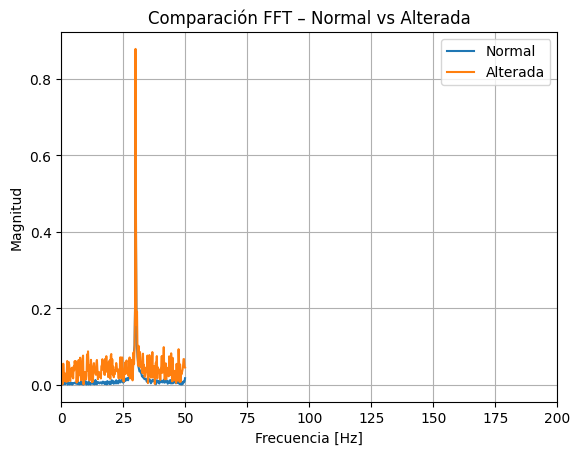

In [17]:
plt.figure()
plt.plot(freqs_n, mag_n, label="Normal")
plt.plot(freqs_a, mag_a, label="Alterada")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud")
plt.title("Comparación FFT – Normal vs Alterada")
plt.xlim(0, 200)
plt.grid(True)
plt.legend()
plt.show()


### 8. Interpretación de Resultados (FFT)

El espectro de frecuencia muestra un pico dominante en **30 Hz**. Al convertir este valor a velocidad de rotación ($30 \text{ Hz} \times 60$), confirmamos que la máquina está operando a **1800 RPM**, lo cual es coherente con un motor estándar de 4 polos.

Al comparar la señal normal (azul) vs. la señal alterada (naranja), se observan dos fenómenos clave:

1.  **Componente Dominante:** Ambas señales mantienen el pico principal en 30 Hz (1X), indicando que la velocidad de giro es constante.
2.  **Elevación del Piso de Ruido:** Se observa un aumento evidente del nivel general del espectro en la señal alterada. La línea naranja tiene una "base" más alta y errática que la azul. Esto indica una mayor **energía distribuida** en frecuencias no sincrónicas, lo cual es síntoma típico de fricción, irregularidades mecánicas o ruido de proceso introducido.

**Conclusión:**
El análisis en frecuencia permitió aislar el componente útil (rotación) del ruido de fondo, demostrando que la alteración inyectada no cambió la velocidad de la máquina, pero sí introdujo inestabilidad general en el sistema (ruido de banda ancha).